In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from tqdm import tqdm_notebook as tqdm #进度条
from joblib import Parallel, delayed #临时处理库
from tempfile import TemporaryDirectory as TD  #创建临时文件库

import rasterio as rio
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.windows import Window  #按照窗格读取
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show # rasterio绘图工具

from shapely.geometry import Polygon, box

from sklearn.preprocessing import MinMaxScaler

In [2]:
import warnings
warnings.filterwarnings("ignore")
from osgeo import gdal
import rasterio as rio
print(rio.__version__)

1.3.2


In [3]:
# path_geodata = Path(r"E:\GEODATA\Raw Data")
# path_luc = Path(r"E:\GEODATA\Raw Data\武汉大学30m土地利用\武汉大学30m_1985-2019rawdata")
path_basic = Path(r"D:\Vancouver data\Van_Burn_NewW")
path_geodata = path_basic /"geodata_raw2"
path_luc = path_geodata / "luc_raw"
path_out = path_basic / "out2"

In [4]:
gdf_roi = gpd.read_file("D:\Vancouver data\Van_Burn_NewW/Van_Burn_NewW_boundary.shp").to_crs(32610)
gdf_roi['FullName'].isin(['City of Burnaby','Vancouver'])

0     True
1     True
2    False
3    False
Name: FullName, dtype: bool

In [5]:
gdf_roi = gdf_roi.dissolve("Region").reset_index().iloc[:,:2]
gdf_roi 

,Region,geometry
0,central,"POLYGON ((508887.570 5451827.140, 508563.458 5..."


In [6]:
gdf_roi_32610 = gdf_roi.copy()
gdf_roi = gdf_roi.to_crs("epsg:32610")

In [7]:
def unvisible_spines(ax):
    ax.spines[:].set_visible(False)
    ax.tick_params("both", length=0)
    ax.set_xticks([])
    ax.set_yticks([])

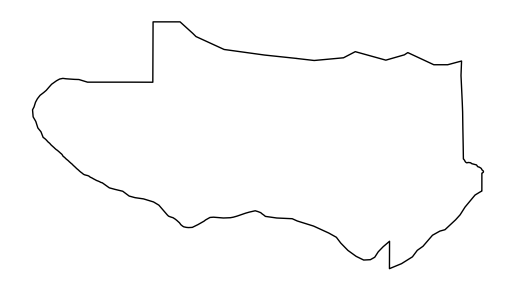

In [8]:
ax = gdf_roi_32610.plot(color="none")
unvisible_spines(ax)

In [9]:
gdf_roi.bounds

,minx,miny,maxx,maxy
0,480373.9743,5.446940e+06,509100.1572,5.462663e+06


In [10]:
xmin, ymin, xmax, ymax = gdf_roi.bounds.values[0]

In [11]:
resolution=200
xmin

480373.9742999999

In [12]:
np.arange(480000,509100+200,200)

array([480000, 480200, 480400, 480600, 480800, 481000, 481200, 481400,
       481600, 481800, 482000, 482200, 482400, 482600, 482800, 483000,
       483200, 483400, 483600, 483800, 484000, 484200, 484400, 484600,
       484800, 485000, 485200, 485400, 485600, 485800, 486000, 486200,
       486400, 486600, 486800, 487000, 487200, 487400, 487600, 487800,
       488000, 488200, 488400, 488600, 488800, 489000, 489200, 489400,
       489600, 489800, 490000, 490200, 490400, 490600, 490800, 491000,
       491200, 491400, 491600, 491800, 492000, 492200, 492400, 492600,
       492800, 493000, 493200, 493400, 493600, 493800, 494000, 494200,
       494400, 494600, 494800, 495000, 495200, 495400, 495600, 495800,
       496000, 496200, 496400, 496600, 496800, 497000, 497200, 497400,
       497600, 497800, 498000, 498200, 498400, 498600, 498800, 499000,
       499200, 499400, 499600, 499800, 500000, 500200, 500400, 500600,
       500800, 501000, 501200, 501400, 501600, 501800, 502000, 502200,
      

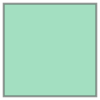

In [13]:
box(0,0,1,1)#xmin,ymin,xmax,ymax

In [16]:
xmin, ymin, xmax, ymax = gdf_roi.bounds.values[0]
resolution = 200
xa = np.arange(xmin // resolution, (xmax // resolution + 1)) * resolution
ya = np.arange(ymax // resolution, ymin // resolution - 1, -1) * resolution
gdf_grid = (
    gpd.GeoDataFrame(
        [[x, y] for x in xa for y in ya],
         geometry=[box(x, y - resolution, x + resolution, y) for x in xa for y in ya],
        crs="epsg:32610"
     ).sjoin(gdf_roi).iloc[:, :3] #sj--->spacejoin 和polygon进行连接
     .drop_duplicates()
     .reset_index(drop=True)
     .rename(columns={0: "x", 1: "y"})
 )

<AxesSubplot: >

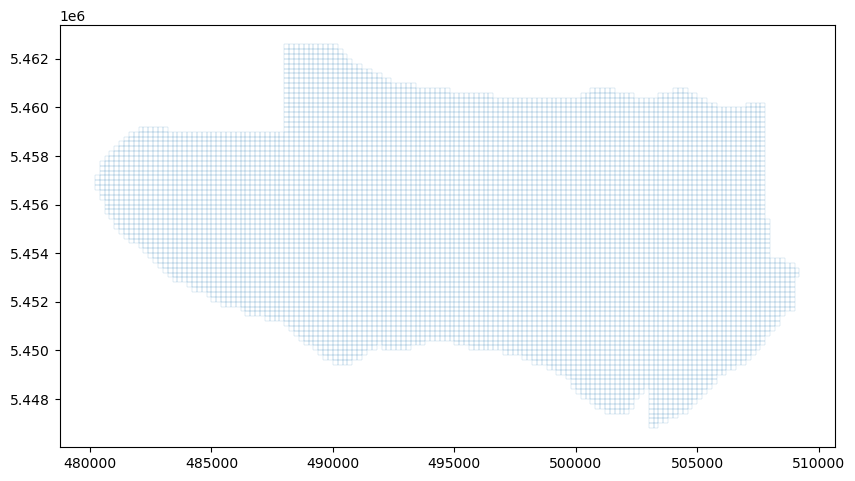

In [17]:
gdf_grid.boundary.plot(figsize=(10,10),lw=0.1)

In [18]:
gdf_grid.to_file("D:\Vancouver data\Van_Burn_NewW/roi_grid200by00.shp")

In [20]:
#gdf_grid = gpd.read_file("D:\Vancouver data\Van_Burn_NewW/fishnet600.shp")
gdf_grid200 = gpd.read_file("D:\Vancouver data\Van_Burn_NewW\Van_Burn_NewW_fishnet.shp")

<AxesSubplot: >

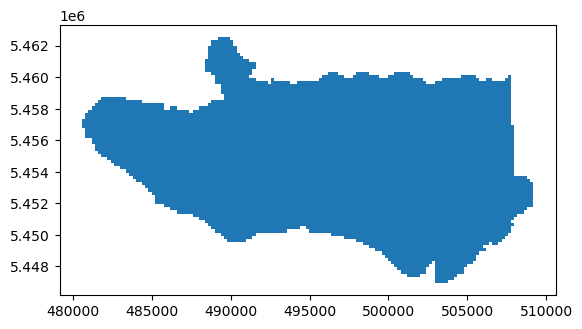

In [21]:
gdf_grid200.plot()

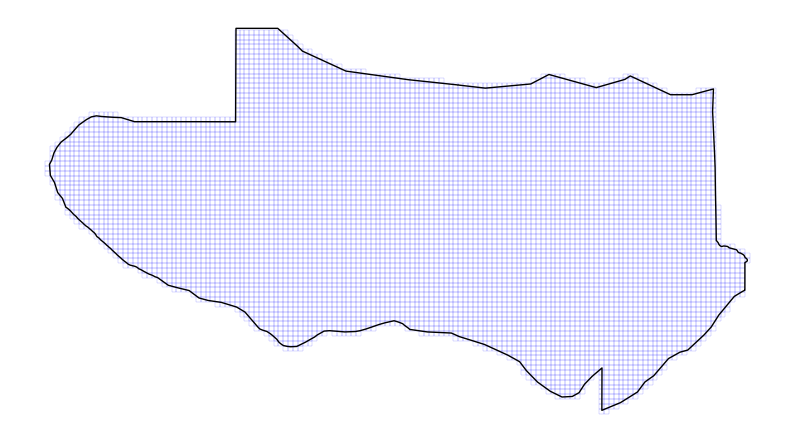

In [22]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_grid.plot(ax=ax, color='none', edgecolor='b', lw=0.1)
gdf_roi.plot(ax=ax, color='none', edgecolor='k');
unvisible_spines(ax)

In [23]:
gdf_roi.bounds.values[0]#加星号 分开传

array([ 480373.9743, 5446939.6245,  509100.1572, 5462662.7588])

In [24]:
buffer_bounds = box(*gdf_roi.bounds.values[0]).buffer(100)
gdf_box = gpd.GeoDataFrame({"id": [0]}, geometry=[buffer_bounds], crs="epsg:32610")
#gdf_box = gdf_box.to_crs(4326)
#buffer_bounds = box(*gdf_box.geometry[0].bounds)
#gdf_box = gpd.GeoDataFrame({"id": [0]}, geometry=[buffer_bounds], crs="epsg:4326")

# gdf_box.to_file(path_out / "roi_box.shp")

<AxesSubplot: >

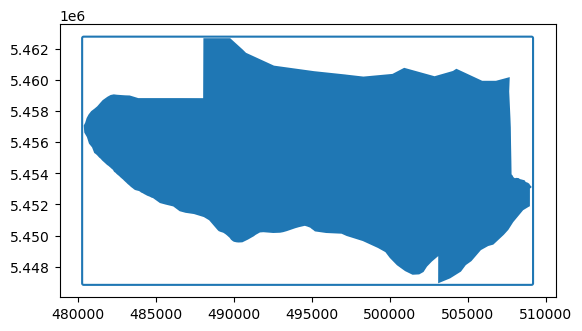

In [25]:
ax=gdf_box.boundary.plot()
gdf_roi.plot(ax=ax)

In [26]:
# D:\Vancouver data\Van_Burn_NewW\Van_Burn_NewW_fishnet600
gdf_grid200= gpd.read_file("D:\Vancouver data\Van_Burn_NewW\Van_Burn_NewW_fishnet.shp")

In [27]:
from tqdm import tqdm as tqdm #进度条

In [28]:
path_luc_split = Path('D:\Vancouver data\Van_Burn_NewW\luc_split200')
path_2= Path(r'D:\Vancouver data\Van_Burn_NewW')

In [29]:
with rio.open(path_2/ f"Van_Bur_New_forestttt2014.tif") as f:
    meta = f.meta
    for oid,geo_ in tqdm(enumerate(gdf_grid200.geometry.values)):
        data, transform_ = mask(f, [geo_], crop=True)
        
        meta.update({"height": data.shape[1], "width": data.shape[2], "transform": transform_, "nodata": 0})
        with rio.open(path_luc_split / f"{oid}.tif", "w", **meta) as f_grid:
             f_grid.write(data)

6421it [00:34, 186.48it/s]


In [30]:
data.shape

(1, 41, 41)

# 3  指标计算
https://github.com/martibosch/pylandstats
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0225734 https://pylandstats.readthedocs.io/en/latest/landscape.html

In [31]:
import pylandstats as pls

Module D:\Anaconda3\envs\pyland\lib\site-packages\pylandstats\landscape.py has not been compiled for Transonic-Numba


In [42]:
path_luc_split = Path('D:\Vancouver data\Van_Burn_NewW\luc_split200')
path_luc_split.mkdir(parents=True, exist_ok=True)

In [43]:
def cal_fragmentation_1grid(input_filepath):
    ls = pls.Landscape(input_filepath)
    try:
        ENN_MN = ls.euclidean_nearest_neighbor(class_val=1).mean()
    except:
        ENN_MN = 0
    try:
        LPI = ls.largest_patch_index(class_val=1)
    except:
        LPI = 0
    try:
        dl1_a = ls.total_area(class_val=1)
        AP = dl1_a / (dl1_a + ls.total_area(class_val=2))
    except:
        AP = 0
    try:
        PLAND=ls.proportion_of_landscape(class_val=1)
    except:
        PLAND=0
    return AP, ENN_MN, LPI,PLAND

In [44]:
def unvisible_spines(ax):
    ax.spines[:].set_visible(False)
    ax.tick_params("both", length=0)
    ax.set_xticks([])
    ax.set_yticks([])

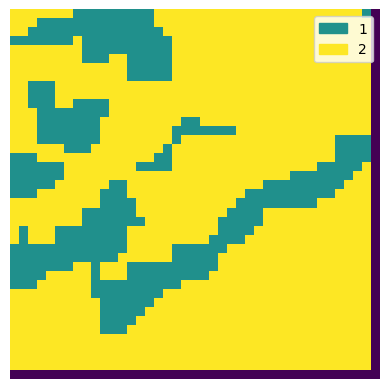

In [45]:
input_filepath = path_luc_split / "0.tif"
ls = pls.Landscape(input_filepath)
ax = ls.plot_landscape(legend=True)
unvisible_spines(ax)

In [46]:
cal_fragmentation_1grid(input_filepath)

(0.24, 23.64302574300937, 13.5, 24.0)

In [47]:
year=2014
path_basic = Path(r"D:\Vancouver data\Van_Burn_NewW")
path_out = path_basic / "out2"
path_luc_split = Path('D:\Vancouver data\Van_Burn_NewW\luc_split200')
path_luc_split.mkdir(parents=True, exist_ok=True)

lst=list(path_luc_split.glob("*.tif"))
lst[0]

WindowsPath('D:/Vancouver data/Van_Burn_NewW/luc_split200/0.tif')

In [49]:
import os
lst = os.listdir('D:\Vancouver data\Van_Burn_NewW\luc_split200')
len(lst)

6421

In [50]:
lst

['0.tif',
 '1.tif',
 '10.tif',
 '100.tif',
 '1000.tif',
 '1001.tif',
 '1002.tif',
 '1003.tif',
 '1004.tif',
 '1005.tif',
 '1006.tif',
 '1007.tif',
 '1008.tif',
 '1009.tif',
 '101.tif',
 '1010.tif',
 '1011.tif',
 '1012.tif',
 '1013.tif',
 '1014.tif',
 '1015.tif',
 '1016.tif',
 '1017.tif',
 '1018.tif',
 '1019.tif',
 '102.tif',
 '1020.tif',
 '1021.tif',
 '1022.tif',
 '1023.tif',
 '1024.tif',
 '1025.tif',
 '1026.tif',
 '1027.tif',
 '1028.tif',
 '1029.tif',
 '103.tif',
 '1030.tif',
 '1031.tif',
 '1032.tif',
 '1033.tif',
 '1034.tif',
 '1035.tif',
 '1036.tif',
 '1037.tif',
 '1038.tif',
 '1039.tif',
 '104.tif',
 '1040.tif',
 '1041.tif',
 '1042.tif',
 '1043.tif',
 '1044.tif',
 '1045.tif',
 '1046.tif',
 '1047.tif',
 '1048.tif',
 '1049.tif',
 '105.tif',
 '1050.tif',
 '1051.tif',
 '1052.tif',
 '1053.tif',
 '1054.tif',
 '1055.tif',
 '1056.tif',
 '1057.tif',
 '1058.tif',
 '1059.tif',
 '106.tif',
 '1060.tif',
 '1061.tif',
 '1062.tif',
 '1063.tif',
 '1064.tif',
 '1065.tif',
 '1066.tif',
 '1067.tif',
 

In [51]:
lst[0].split('.')

['0', 'tif']

In [52]:
vls = [[i] + i.split('.') for i in lst]

In [53]:
vls

[['0.tif', '0', 'tif'],
 ['1.tif', '1', 'tif'],
 ['10.tif', '10', 'tif'],
 ['100.tif', '100', 'tif'],
 ['1000.tif', '1000', 'tif'],
 ['1001.tif', '1001', 'tif'],
 ['1002.tif', '1002', 'tif'],
 ['1003.tif', '1003', 'tif'],
 ['1004.tif', '1004', 'tif'],
 ['1005.tif', '1005', 'tif'],
 ['1006.tif', '1006', 'tif'],
 ['1007.tif', '1007', 'tif'],
 ['1008.tif', '1008', 'tif'],
 ['1009.tif', '1009', 'tif'],
 ['101.tif', '101', 'tif'],
 ['1010.tif', '1010', 'tif'],
 ['1011.tif', '1011', 'tif'],
 ['1012.tif', '1012', 'tif'],
 ['1013.tif', '1013', 'tif'],
 ['1014.tif', '1014', 'tif'],
 ['1015.tif', '1015', 'tif'],
 ['1016.tif', '1016', 'tif'],
 ['1017.tif', '1017', 'tif'],
 ['1018.tif', '1018', 'tif'],
 ['1019.tif', '1019', 'tif'],
 ['102.tif', '102', 'tif'],
 ['1020.tif', '1020', 'tif'],
 ['1021.tif', '1021', 'tif'],
 ['1022.tif', '1022', 'tif'],
 ['1023.tif', '1023', 'tif'],
 ['1024.tif', '1024', 'tif'],
 ['1025.tif', '1025', 'tif'],
 ['1026.tif', '1026', 'tif'],
 ['1027.tif', '1027', 'tif'],
 [

In [54]:
df = pd.DataFrame(vls,columns=['file_name', 'fid','tif'])

In [62]:
df.head()

,file_name,fid,tif
0,0.tif,0,tif
1,1.tif,1,tif
2,10.tif,10,tif
3,100.tif,100,tif
4,1000.tif,1000,tif


In [63]:
type(df['fid'] )

pandas.core.series.Series

In [64]:
data = []
for input_filepath in tqdm(list(path_luc_split.glob("*.tif"))):
    data2=data.append(cal_fragmentation_1grid(input_filepath))
    

df_fragmentation1 = pd.DataFrame(data, columns=["AP", "ENN_MN", "LPI","PLAND"])  #AP, ENN_MN, LPI,PLAND
df_fragmentation1["fid"]= df['fid']
df_fragmentation1.to_csv(path_out / f"fragmentation200_{year}.csv")

100%|██████████████████████████████████████████████████████████████████████████████| 6421/6421 [01:30<00:00, 70.65it/s]


In [65]:
len(list(path_luc_split.glob("*.tif")))

6421

In [66]:
import pandas as pd

In [67]:
year1 = 2014

In [68]:
df_fragmentation1200 = pd.read_csv(path_out / f"fragmentation200_{year1}.csv", index_col=0)
df_fragmentation1200

,AP,ENN_MN,LPI,PLAND,fid
0,0.240000,23.643026,13.500000,24.000000,0
1,0.043750,15.786893,3.000000,4.375000,1
2,0.157697,14.239965,13.829787,15.769712,10
3,0.015625,226.274170,1.062500,1.562500,100
4,0.569375,10.000000,31.000000,56.937500,1000
...,...,...,...,...,...
6416,0.095000,14.089333,0.937500,9.500000,995
6417,0.096875,13.571043,1.500000,9.687500,996
6418,0.133750,17.168855,3.187500,13.375000,997
6419,0.353125,13.368074,22.437500,35.312500,998


In [70]:
df_fragmentation1200["gid"] = [int(i.stem) for i in path_luc_split.glob("*.tif")] 
df_fragmentation1200["gid"]
df_fragmentation1200 = df_fragmentation1200.set_index("gid").sort_index()
df_fragmentation1200

,AP,ENN_MN,LPI,PLAND,fid
gid,,,,,
0,0.240000,23.643026,13.5000,24.0000,0
1,0.043750,15.786893,3.0000,4.3750,1
2,0.000000,0.000000,NaN,0.0000,2
3,0.081875,NaN,8.1875,8.1875,3
4,0.252500,21.283351,9.5000,25.2500,4
...,...,...,...,...,...
6416,0.000000,0.000000,NaN,0.0000,6416
6417,0.000000,0.000000,NaN,0.0000,6417
6418,0.000000,0.000000,NaN,0.0000,6418


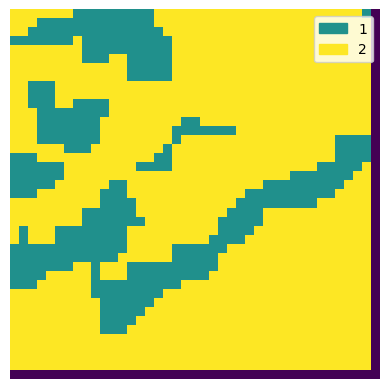

In [77]:
input_filepath = path_luc_split / "0.tif"
ls = pls.Landscape(input_filepath)
ax = ls.plot_landscape(legend=True)
unvisible_spines(ax)

In [78]:
cal_fragmentation_1grid(input_filepath)

(0.24, 23.64302574300937, 13.5, 24.0)

In [79]:
df_fragmentation1200.index.name = None

df_fragmentation1200.to_csv(path_out / f"fragmentation200_revise_{year1}.csv")

# df_fragmentation1

In [80]:
df_fragmentation1200 = pd.read_csv(path_out / f"fragmentation200_revise_{year1}.csv", index_col=0)

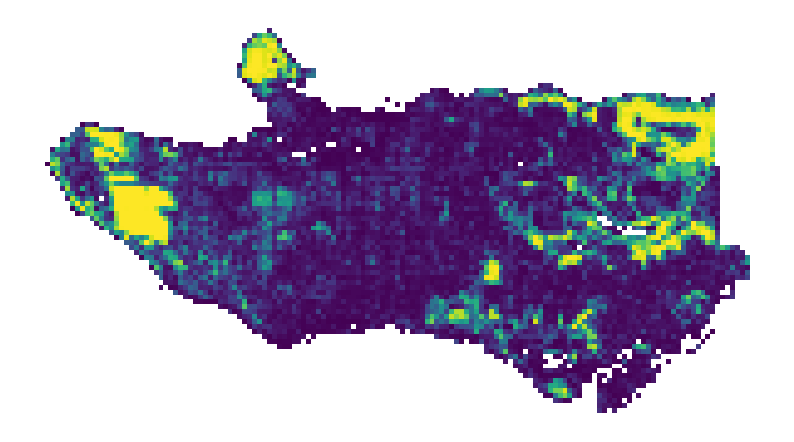

In [83]:
ax=gdf_grid200.join(df_fragmentation1200).plot("LPI",figsize=(10,10))
unvisible_spines(ax)